In [124]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from scipy.special import digamma
from scipy.special import gamma 
from scipy.special import loggamma 
%matplotlib inline
#%matplotlib qt5
plt.rcParams.update({'figure.figsize': (8.0, 6.0), 'font.size': 11})

## Gaussian Mixture Model (GMM)
* probability density finction

$$
\large
\DeclareMathOperator{\NormalGamma}{NormalGamma}
\DeclareMathOperator{\Norm}{\mathcal{N}}
\DeclareMathOperator{\Gam}{Gam}
\DeclareMathOperator{\e}{exp}
p(x|\boldsymbol{\mu}, \boldsymbol{\sigma^2}, \boldsymbol{\pi}) = \sum_{k=1}^{K} \Norm(x|\mu_k, \sigma^2_k) \pi_k
$$

* $\boldsymbol{\mu}$ is the vector of $K$ means
* $\boldsymbol{\sigma}^2$ is the vector of $K$ variances
* $\boldsymbol{\pi}$ is the vector of $K$ weights such that $\sum_{k=1}^K \pi_k = 1$ 

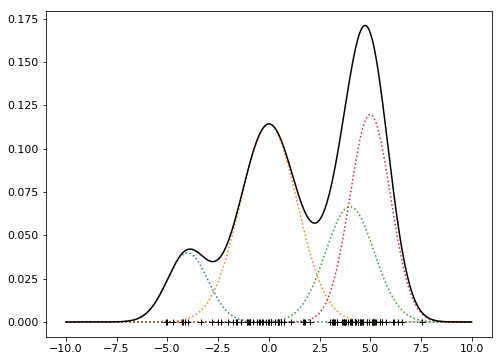

In [125]:
# Plot GMM pdf together with the individual components pdfs; return the GMM pdf line
t = np.linspace(-10,10,1000)
def plot_GMM(t, mus, sigmas, pis):
  p_xz = sps.norm.pdf(t[:,np.newaxis], mus, sigmas) * pis # all GMM components are evaluated at once
  px = np.sum(p_xz, axis=1)
  plt.plot(t, p_xz, ':')
  plt.plot(t, px, 'k', label='ML estimate')
  return px

#Handcraft some GMM parameter 
mus = [-4.0, 0.0, 4.0, 5]
sigmas = [1.0, 1.4, 1.2, 1]
pis = [0.1, 0.4, 0.2, 0.3]


plt.clf()
true_GMM_pdf = plot_GMM(t, mus, sigmas, pis)

# Generate N datapoints from this GMM
N = 100
Nc = sps.multinomial.rvs(N, pis) # Draw observation counts for each component from multinomial distribution
x = sps.norm.rvs(np.repeat(mus, Nc), np.repeat(sigmas, Nc))
np.random.shuffle(x)
plt.plot(x, np.zeros_like(x), '+k')

#Log likelihood of the training data evaluated using the true distribution
true_tll = np.sum(logsumexp(sps.norm.logpdf(x[:,np.newaxis], mus, sigmas) + np.log(pis), axis=1))


## GMM - EM algorithm
* E-step

$$
\DeclareMathOperator{\Norm}{\mathcal{N}}
\DeclareMathOperator{\eeta}{\boldsymbol{\eta}}
\gamma_{nc}=P(z_n=c|x_n,\eeta^{old})=\frac{p(x_n|z_n=c,\eeta^{old})P(z_n=c|\eeta^{old})}{p(x_n|\eeta^{old})}
=\frac{\mathcal{N}(x_n|\mu_c^{old}{\sigma_c^2}^{old})\pi_c^{old}}{\sum_{k}\mathcal{N}(x_n|\mu_{k}^{old},{\sigma_{k}^2}^{old})\pi_{k}^{old}}
$$

* M-step

$$
\begin{align}
\mu_c^{new}        & =\frac{\sum_n \gamma_{nc}x_n}{\sum_n \gamma_{nc}}\\
{\sigma_c^2}^{new} & =\frac{\sum_n \gamma_{nc}(x_n-\mu_c^{new})^2}{\sum_n \gamma_{nc}}\\
\pi_c              & =\frac{\sum_n \gamma_{nc}}{N}
\end{align}
$$

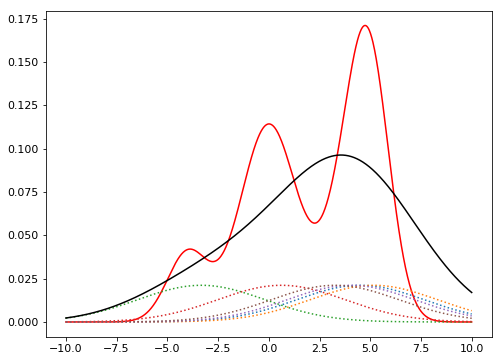

In [126]:
#Choose some initial parameters
C = 6        # number of GMM components 
mus = x[:C]  # we choose few first observations as the initial means
sigmas = np.repeat(np.std(x), C) # sigma for all components is set to std of the the training data
pis = np.ones(C)/C
tll=[]

plt.clf()
plt.plot(t, true_GMM_pdf, 'r')
plot_GMM(t, mus, sigmas, pis);


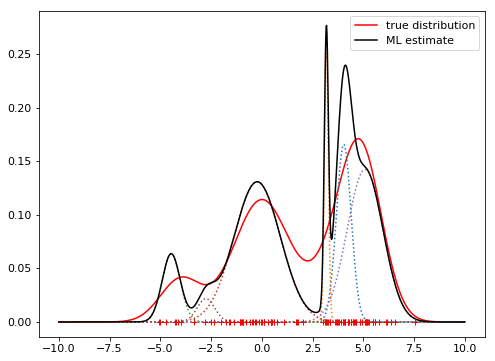

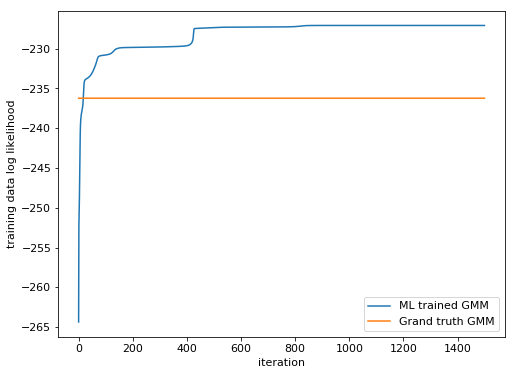

In [138]:
for _ in range(500):
  #E-step
  log_p_xz = sps.norm.logpdf(x[:,np.newaxis], mus, sigmas) + np.log(pis)
  log_p_x = logsumexp(log_p_xz, axis=1, keepdims=True)
  tll.append(log_p_x.sum())

  gammas = np.exp(log_p_xz - log_p_x)
  #M-step
  Nc = gammas.sum(axis=0)
  mus =  x.dot(gammas) / Nc
  sigmas =  np.sqrt((x**2).dot(gammas) / Nc - mus**2) # we use std, not variance!
  pis = Nc / Nc.sum()
    
plot_GMM(t, mus, sigmas, pis)

plt.clf()
plt.plot(t, true_GMM_pdf, 'r', label='true distribution')
ml_GMM_pdf=plot_GMM(t, mus, sigmas, pis);
plt.plot(x, np.zeros_like(x), '+r')
plt.legend()

plt.figure()
plt.plot(tll, label='ML trained GMM')
log_p_xz = sps.norm.logpdf(x[:,np.newaxis], mus, sigmas) + np.log(pis)
plt.plot(np.repeat(true_tll, len(tll)), label='Grand truth GMM')
plt.ylabel('training data log likelihood')
plt.xlabel('iteration');
plt.legend()

## Variational Bayes 

$$
\DeclareMathOperator{\aalpha}{\boldsymbol{\alpha}}
\DeclareMathOperator{\bbeta}{\boldsymbol{\beta}}
\DeclareMathOperator{\NN}{\mathbf{N}}
\DeclareMathOperator{\ppi}{\boldsymbol{\pi}}
\DeclareMathOperator{\mmu}{\boldsymbol{\mu}}
\DeclareMathOperator{\llambda}{\boldsymbol{\lambda}}
\DeclareMathOperator{\diff}{\mathop{}\mathrm{d}}
\DeclareMathOperator{\zz}{\mathbf{z}}
\DeclareMathOperator{\XX}{\mathbf{X}}
\DeclareMathOperator{\xx}{\mathbf{x}}
\DeclareMathOperator{\YY}{\mathbf{Y}}
\DeclareMathOperator{\NormalGamma}{\mathcal{NG}}
ln\ p(\mathbf{X})=\mathcal{L}(q) + KL (q||p)
$$

\begin{equation}
\begin{split}
& {\mathcal{L}(q) = \int q(\YY)\ \ln\left\{ \frac{p(\XX,\YY)}{q(\YY)} \right \}d\YY}\\
& {KL (q||p)=-\int q(\YY)\ \ln\left\{ \frac{p(\YY|\XX)}{q(\YY)}\right\}d\YY}
\end{split}
\end{equation}

where $\XX=\{x_1, x_2,...,x_N\}$ is the data (i.e. all observed variables), $\YY=\{\zz,\mmu, \llambda,\ppi\}=\{z_1, z_2,\dots,z_N,\mu_1, \lambda_1,\mu_2, \lambda_2,\dots,\mu_C, \lambda_C,\pi_1,\pi_2,\dots,\pi_C\}$ is the collection of all the hidden variables (incluting GMM parameters) and the approximate posterior distribution
$p(\ppi,\mmu, \llambda,\zz | \XX)\approx q(\ppi,\mmu,\llambda)q(\zz)=q(\ppi)\prod_{c=1}^C q(\mu_c,\lambda_c)\prod_{n=1}^N q(z_n)$

* VB GMM update for $q(\mmu, \llambda)=\prod_{c=1}^C q(\mu_c,\lambda_c)$

\begin{equation*}
\begin{split}
q(\mu_c, \lambda_c)^* 
&= \NormalGamma\left(\mu_c,\lambda_c \,\middle|\, \frac{\kappa m +N_c \bar{x}_c}{\kappa+N_c}, \kappa+N_c, a+\frac{N_c}{2},
b+\frac{N_c}{2}\left(v_c+\frac{\kappa (\bar{x}_c-m)^2}{\kappa+N_c}\right)\right)\\
&= \NormalGamma\left(\mu_c,\lambda_c \,\middle|\, \frac{\kappa m + f_c}{\kappa+N_c}, \kappa+N_c, a+\frac{N_c}{2},
b+\frac{1}{2}\left(s_c+\kappa m^2 - \frac{(\kappa m + f_c)^2}{\kappa+N_c} \right)
\right)\\
&= \NormalGamma\left(\mu_c,\lambda_c \,\middle|\, m_c^*, \kappa_c^*, a_c^*, b_c^*, \right)
\end{split}
\end{equation*}

\begin{equation*}
\begin{split}
N_c & = \sum_n \gamma_{nc} \\
\bar{x}_c &=\frac{\sum_n \gamma_{nc}x_n}{\sum_n \gamma_{nc}} \\
v_c &=\frac{\sum_n \gamma_{nc}(x_n-\bar{x}_n)^2}{\sum_n \gamma_{nc}}\\
f_c &=\sum_n \gamma_{nc}x_n \\
s_c &=\sum_n \gamma_{nc}x_n^2
\end{split}
\end{equation*}


* VB GMM update for $q(\ppi)$

\begin{equation*}
\begin{split}
q(\ppi)^* &=\sum_c \sum_N \gamma_{nc} \ln \mathrm{Cat}(z_n=c|\ppi)+ \ln \mathrm{Dir}(\ppi|\aalpha)+const\\
&=\mathrm{Dir}(\ppi|\aalpha+\NN)\\
&=\mathrm{Dir}(\ppi|\aalpha^*)\\
\end{split}
\end{equation*}

\begin{equation*}
\begin{split}
\NN&=[N_1,N_2\dots,N_C]\\
N_c&=\sum_n \gamma_{nc}
\end{split}
\end{equation*}

* VB GMM update for $q(\mathbf{z})=\prod_{n=1}^N q(z_n)$

\begin{equation*}
\begin{split}
q(z_n=c)^* &= \gamma_{nc} = \frac{\rho_{nc}}{\sum_k{\rho_{nk}}}\\\\\
\ln \rho_{nc} &= \iint q(\mu_c, \lambda_c) \ln \mathcal{N}(x;\mu_c,\lambda_c^{-1}) \diff\mu_c \diff\lambda_c &+&\int q(\ppi)\ln \mathrm{Cat}(z_n=c|\ppi)  \diff\ppi\\
&= \frac{1}{2}\left(\psi(a_c^*)-\ln b_c^*-\frac{1}{\kappa_c^*}-\frac{a_c^*}{b_c^*}(x_n-m_c^*)^2-\ln(2\pi)\right)&+&\ \psi(\alpha_c^*)-\psi\Big(\sum_c\alpha_c^*\Big)\\\\
%\ln q(z_n=c)^* &= \ln \rho_{nc} + const
\end{split}
\end{equation*}

* VB GMM approximate posterior predictive distribution
$$\begin{align*}
\\
p(x' \mid \mathbf{x}) 
\approx \iiint p(x'|\mmu, \llambda,\ppi) q(\mmu, \llambda,\ppi) \diff\mmu \diff\llambda \diff\ppi 
=\sum_c St\left(x'|m_c^*,2a_c^*,\frac{a_c^* \kappa_c^*}{b_c^*(\kappa_c^*+1)}\right)\frac{\alpha_c^*}{\sum_c \alpha_c^*}\\
\\
\end{align*}$$


* Calculation of Evidence Lower Bound (ELBO)

\begin{equation}
\begin{split}
\mathcal{L}(q) &= E_{q(\zz,\ppi,\mmu,\llambda)}\left\lbrace \ln\left(\frac{p(\xx,\zz,\ppi,\mmu,\llambda)}{q(\zz,\ppi,\mmu,\llambda)}\right)\right\rbrace\\
&= E_{q(\zz)}\left\{ E_{q(\mmu,\llambda)}\left\{\ln\ p(\xx|\zz,\mmu,\llambda)\} 
 + E_{q(\ppi)}\{\ln p(\zz|\ppi)\right\}\right\}
 - E_{q(\zz)}\{\ln q(\zz)\}
 - E_{q(\ppi})\left\{\ln \frac{q(\ppi)}{p(\ppi)}\right\} 
 - E_{q(\mmu,\llambda)}\left\{\ln \frac{q(\mmu,\llambda)}{p(\mmu,\llambda)}\right\}\\
&= \sum_n\sum_c\left\{\gamma_{nc} \ln \rho_{nc} \right\}
 - \sum_n\sum_c\left\{\gamma_{nc} \ln \gamma_{nc} \right\}
 - KL(q(\ppi)||p(\ppi)) 
 - KL(q(\mmu,\llambda)||p(\mmu,\llambda))\\
&= \sum_n \ln \sum_c \rho_{nc}
 - KL(q(\ppi)||p(\ppi)) 
 - KL(q(\mmu,\llambda)||p(\mmu,\llambda))
\end{split}
\end{equation}

where the Kulback-Leibrer divergences

$$
KL(\mathrm{Dir}(\ppi|\aalpha)\,||\,\mathrm{Dir}(\ppi|\bbeta)) = 
\log \Gamma\Big(\sum_c\alpha_c\Big) – \sum_c \log \Gamma(\alpha_c) -\log \Gamma\Big(\sum_c\beta_c\Big) + \sum_c \log \Gamma(\beta_c) + \sum_c (\alpha_c – \beta_c) \left(\psi(\alpha_c)-\psi\Big(\sum_c\alpha_c\Big)\right)
$$

\begin{equation}
\begin{split}
KL\left(\NormalGamma(\mu,\lambda|m_1,\kappa_1,a_1,b_1)\,||\NormalGamma(\mu,\lambda|m_2,\kappa_2,a_2,b_2)\right)
=\frac{1}{2} \left(\frac{a_1}{b_1} \kappa_2 (m_2-m_1)^2 + \frac{\kappa_2}{\kappa_1} - \ln\frac{\kappa_2}{\kappa_1} - 1\right) + a_2 \ln\frac{b_1}{b_2} - \ln\frac{\Gamma(a_1)}{\Gamma(a_2)} + (a_1-a_2) \psi(a_1)-(b_1-b_2) \frac{a_1}{b_1}
\end{split}
\end{equation}


In [139]:
def NormalGamma(mu, lmbd, m, kappa, a, b):
    # sps.norm.pdf takes mean and std (not precision), therefore 1.0/np.sqrt()
    # sps.gamma.pdf takes shape and scale (not rate), therefore 1.0/b
    return sps.norm.pdf(mu, m, 1.0/np.sqrt(lmbd*kappa))* sps.gamma.pdf(lmbd, a, scale=1.0/b)

def NormalGamma_plot(m0, kappa0, a0, b0, limits):
   mu_vals, lmbd_vals = np.meshgrid(np.linspace(limits[0], limits[1], 500), np.linspace(limits[2], limits[3], 500))
   pdf = NormalGamma(mu_vals, lmbd_vals, m0, kappa0, a0, b0)
   plt.imshow(pdf, origin='lower', cmap='Greys', extent=limits)
   plt.xlabel('$\mu$'); plt.ylabel('$\lambda$')

def plot_VB_GMM(t, mN, kappaN, aN, bN, alphaN):
  # VB approximate posterior predictive for GMM (i.e. mixture of student's-t)
  pis = alphaN/alphaN.sum()
  p_xz = sps.t.pdf(t[:,np.newaxis], loc=mN, df=2*aN, scale=np.sqrt(bN*(kappaN+1)/aN/kappaN)) * pis 
  px = np.sum(p_xz, axis=1)
  plt.plot(t, p_xz, ':')
  plt.plot(t, px, 'k', label='VB posterior predictive')
  return px

def NormalGamma_rvs(m, kappa, a, b, N):
    # Sample from NormalGamma distribution
    lmbd = sps.gamma.rvs(a, scale=1.0/b, size=N)
    mu = sps.norm.rvs(m, 1.0/np.sqrt(lmbd*kappa), N)
    return mu, lmbd

def NormalGamma_KL(m1, kappa1, a1, b1, m2, kappa2, a2, b2):
    # Calculates KL(p1||p2) for two NormalGamma distributions 
    return 0.5 * (a1/b1 * kappa2*(m2-m1)**2 + kappa2/kappa1 - np.log(kappa2/kappa1) - 1
                 ) + a2*np.log(b1/b2) - loggamma(a1) + loggamma(a2) + (a1-a2)*digamma(a1)-(b1-b2)*a1/b1

def Dirichlet_KL(alpha1, alpha2):
    # Calculates KL(p1||p2) for two Dirichlet distributions 
    return (loggamma(np.sum(alpha1)) - np.sum(loggamma(alpha1)) 
          - loggamma(np.sum(alpha2)) + np.sum(loggamma(alpha2))
          + np.sum((alpha1 - alpha2)*(digamma(alpha1)-digamma(np.sum(alpha1)))))

#Choose some initial parameters
C = 6        # number of GMM components 

#hyperparameters for gamma distribution for precission term (lambda)
[a,b]=[0.05,0.05] 
#hyper parameters for normal distribution for mean term (mu)
kap=0.05
ms=0.0 #dummy initialization of m terms

#hyperparameter for the weights
alpha=np.ones(C)

#use the statistics that come from the EM to initialize the model
gammas = np.exp(log_p_xz - log_p_x)
ELBO = []

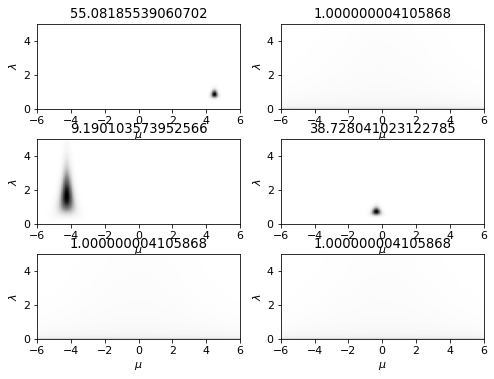

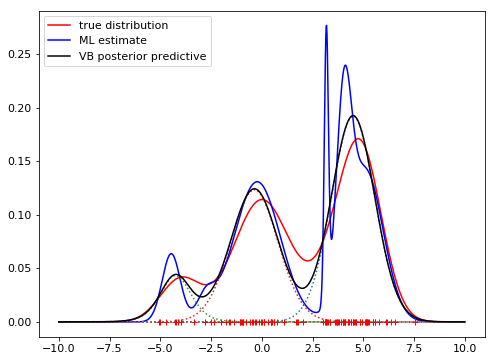

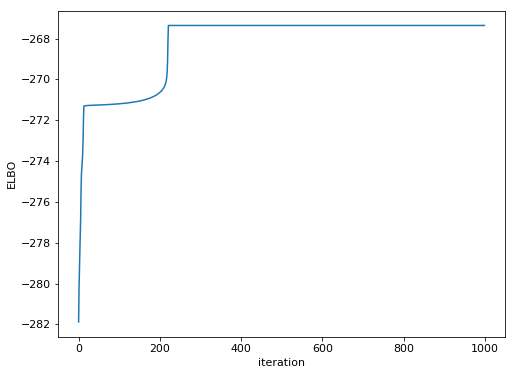

In [142]:
for _ in range(500):
    #statistics
    Nc = gammas.sum(axis=0)
    fc =  x.dot(gammas)
    sc =  (x**2).dot(gammas)

    #hyperparameters for the normal gamma distribution
    kn = kap + Nc
    mn = (kap*ms + fc) / kn
    an = a + 0.5*Nc
    bn = b + 0.5 * (sc + kap * ms**2 - kn * mn**2)
    
    #update for the weights
    alphan=alpha+Nc
    
    #update for the assignments of frames to gaussians
    logRho= 0.5* (digamma(an)-np.log(bn) - 1/kn - an/bn*(x[:,np.newaxis]-mn)**2 - np.log(2*np.pi)
                 ) + digamma(alphan)-digamma(np.sum(alphan))         
    logsumRho = logsumexp(logRho, axis=1, keepdims=True)
    gammas=np.exp(logRho-logsumRho)
    #print(np.sum(NormalGamma_KL(mn, kn, an, bn, ms, kap, a, b)))
    #print(Dirichlet_KL(alphan, alpha))
    #print((alphan, alpha))
    ELBO.append(sum(logsumRho) - np.sum(NormalGamma_KL(mn, kn, an, bn, ms, kap, a, b)) - Dirichlet_KL(alphan, alpha))



#plot update of mu and labmda parameters
#plt.figure()
#plt.clf()
plt.figure(1)
for i in range(C):
   plt.subplot(3,2,i+1)
   plt.title(alphan[i])
   NormalGamma_plot(mn[i], kn[i], an[i], bn[i], limits=[-6, 6, 0.001, 5])
plt.figure(2)
plt.plot(t, true_GMM_pdf, 'r', label='true distribution')
plt.plot(t, ml_GMM_pdf, 'b', label='ML estimate')
vb_GMM_pdf=plot_VB_GMM(t, mn, kn, an, bn, alphan);
plt.plot(x, np.zeros_like(x), '+r');
plt.legend()
plt.figure(3)
plt.plot(ELBO)
plt.ylabel('ELBO')
plt.xlabel('iteration');

Text(0.5, 1.0, 'Samples from posterior')

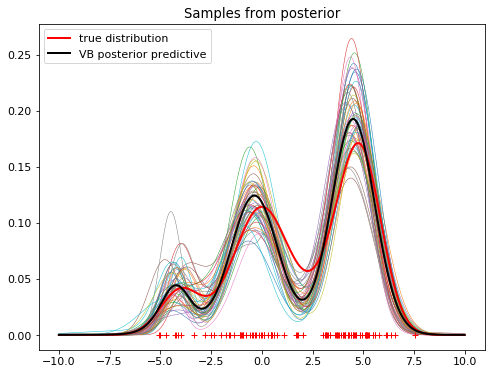

In [143]:
plt.figure(4)
for i in range(50):
  mus_sampled, lmbds_sampled = NormalGamma_rvs(mn, kn, an, bn, 6)
  pis_sampled = sps.dirichlet.rvs(alphan)
  #plot_GMM(t, mus_sampled, lmbds_sampled, pis_sampled)
  plt.plot(t, sps.norm.pdf(t[:,np.newaxis], mus_sampled, 1./np.sqrt(lmbds_sampled)).dot(pis_sampled.T), lw=0.5)
plt.plot(t, true_GMM_pdf, 'r', lw=2, label='true distribution')
plt.plot(t, vb_GMM_pdf, 'k',lw=2, label='VB posterior predictive')
plt.plot(x, np.zeros_like(x), '+r')
plt.legend()
plt.title('Samples from posterior')

In [87]:
# This code allows to "remove" one of the components.
# If we got stuck in a local optimum, this might improve ELBO (after few more iterations).
logRho[:,3]=-100
logsumRho = logsumexp(logRho, axis=1, keepdims=True)
gammas=np.exp(logRho-logsumRho)